In [2]:
import os
import copy
import easydict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload 2

# log graph

[  295   443   591   739   887  1035  1183  1331  1479  1627  1775  1923
  2071  2219  2367  2515  2663  2811  2959  3107  3255  3403  3551  3699
  3847  3995  4143  4291  4439  4587  4735  4883  5031  5179  5327  5475
  5623  5771  5919  6067  6215  6363  6511  6659  6807  6955  7103  7251
  7399  7547  7695  7843  7991  8139  8287  8435  8583  8731  8879  9027
  9175  9323  9471  9619  9767  9915 10063 10211 10359 10507 10655 10803
 10951 11099 11247 11395 11543 11691 11839 11987 12135 12283 12431 12579
 12727 12875 13023 13171 13319 13467 13615 13763 13911 14059 14207 14355
 14503 14651 14799 14947 15095 15243 15391 15539 15687 15835 15983 16131
 16279 16427 16575 16723 16871 17019 17167 17315 17463 17611 17759 17907
 18055 18203 18351 18499 18647 18795 18943 19091 19239 19387 19535 19683
 19831 19979 20127 20275 20423 20571 20719 20867 21015 21163 21311 21459
 21607 21755 21903 22051 22199 22347 22495 22643 22791 22939 23087 23235
 23383 23531 23679 23827 23975 24123 24271 24419 24

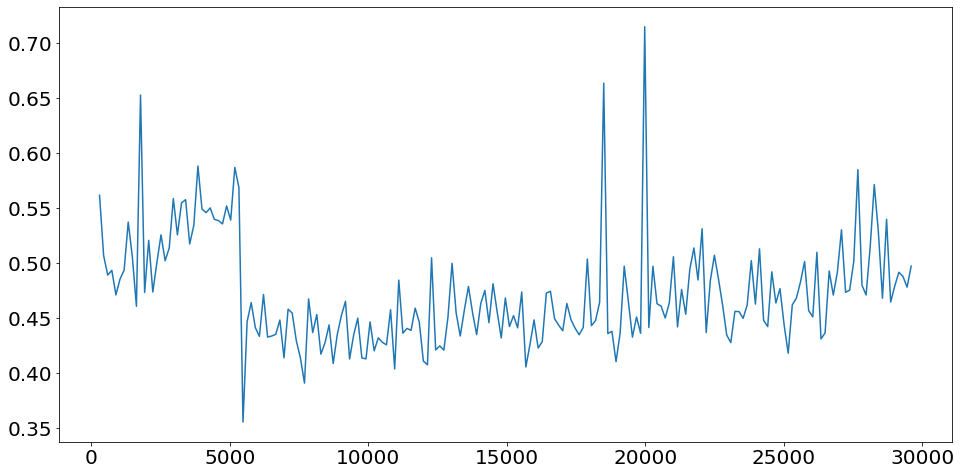

In [6]:
fig, axes = plt.subplots(1, 1, sharey=False, figsize=(16,8))

def plot_loss_logs(axes, filenames):
    for i, filename in enumerate(filenames):
        file_log = pd.read_csv(filename)
        log = np.array(file_log['valid_infect_mse'])
        xs = log.nonzero()[0]
        print(xs)
        ys = log[log.nonzero()[0]]
        print(ys)
        print(np.min(ys))
        axes.plot(xs, ys, label=filename)
        axes.tick_params(axis='both', which='major', labelsize=20)

filenames = ['./results/valid_flu_infect_real_feb_mse_lr0.001_d296-0-148_s7_catTrue_tempFalse_allFalse_lstm-h-dim100_lstm-in-dim50_g-user-dim15_deepTrue.csv']
# filenames = ['./results/1e-2_d14_4_4_s7.csv']
# filenames = ['./result/5e-3_d14_4_4_s7.csv']


plot_loss_logs(axes, filenames)

---
## Risk index calculation - Seoul

In [7]:
import easydict
import torch
import numpy as np
args = easydict.EasyDict()
args['device'] = 'cpu'
args['train_days'] = 296
args['delay_days'] = 0
args['test_days'] = 148
args['num_epochs'] = 250
args['learning_rate'] = 1e-5
args['num_dong'] = 25
args['lstm_num_layers'] = 1
args['lstm_input_size'] = 50
args['lstm_hidden_size'] = 100
args['lstm_sequence_length'] = 7
args['graph_conv_feature_dim_infect'] = 15
args['graph_conv_feature_dim_user'] = 15
args['deep_graph'] = True
args['concat_fc'] = True
args['temp_all_concat'] = False
args['all_concat'] = False
args['loss'] = 'mse'
args['task'] = 'real_feb'
args['data_path'] = '/home/hyungjun/jupyter/KT_covid19/data/'
args['data_normalize'] = True
args['batch_size']=1

In [9]:
from flu_model.data_flu import data_loader_flu
from flu_model.models_flu import GCN_LSTM_flu

train_dataset, train_loader, test_dataset, test_loader, min_max_values = data_loader_flu(args)
model = GCN_LSTM_flu(args)

== data import ==
=== data preprocess done ===


In [12]:
model.load_state_dict(torch.load('./results/models/flu_mse_lr0.001_d296-0-148_s7_catTrue_tempFalse_allFalse_lstm-h-dim100_lstm-in-dim50_g-user-dim15_deepTrue/epochs_35_iter_295.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
model.eval()
mse_criterion = nn.MSELoss()

In [14]:
user_outputs = torch.zeros([len(test_dataset), 25])
test_user_targets_ = torch.torch.zeros([len(test_dataset), 25])
test_infect_targets_ = torch.torch.zeros([len(test_dataset), 25])

val_idx = list(range(len(test_dataset)))
for i in range(0, args.test_days, args.batch_size):
    temp_idx = val_idx[i:i+args.batch_size]
    val_batch = []
    for j in temp_idx:
        val_batch.append(test_dataset[j])
    test_inputs = [x for x, _ in val_batch]
    test_user_targets = torch.tensor([y[0].tolist() for _, y in val_batch])
    test_user_targets_[i] = test_user_targets
    test_infect_targets = torch.tensor([y[1].tolist() for _, y in val_batch])
    test_infect_targets_[i] = test_infect_targets

    user_output, infect_output = model(test_inputs, data_normalize=args.data_normalize, min_max_values=min_max_values, deep_graph=args.deep_graph)
    user_outputs[i] = user_output
#                 user_output = model(train_input, task=args.task, data_normalize=args.data_normalize, min_max_values=min_max_values, deep_graph=args.deep_graph)

In [21]:
sgg = ['dobong', 'dongdaemun', 'dongjak', 'eunpyeong', 'gangbuk', 'gangdong',
       'gangnam', 'gangseo', 'geumcheon', 'guro', 'gwanak', 'gwangjin',
       'jongno', 'junggu', 'jungnang', 'mapo', 'nowon', 'seocho', 'seudaemun',
       'songpa', 'sungbuk', 'sungdong', 'yangcheon', 'yeongdeungpo','yongsan']
population = torch.tensor([34.86, 34.68, 39.73, 45.06, 32.44, 46.6, 56.11,54.69, 
                           24.25, 41.73, 52.08, 36.8, 15.56, 13.15, 40.31, 38.13, 
                           58.72, 39.33, 31.38, 64.7, 45.76, 29.61, 46.94, 39.63, 22.74])
population_density = torch.tensor([16245.81, 24362.70, 24362.70, 16224.11, 13327.88, 17733.51, 
                                   13752.45, 14341.19, 17880.95, 20211.93, 16989.96, 20594.96, 
                                   6347.38, 12691.97, 21460.27, 15654.36, 15121.90, 9181.63, 17569.39,
                                   19951.62, 18008.54, 17846.32, 26316.20, 15025.11, 10476.31])

In [22]:
test_infect_targets_[67]/population_density

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.2714e-05, 0.0000e+00, 5.0333e-04, 1.4843e-04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0891e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7999e-05, 7.9866e-04,
        0.0000e+00])

In [55]:
test_infect_targets_[test_infect_targets_==1]=0

In [24]:
test_infect_targets_[67]/population_density*user_outputs

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  2.9787, 62.6064,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.9787, 62.6064,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 11.9596, 62.6064,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  2.9787, 62.6064,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.9787, 62.6064,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.9787, 62.6064,  0.0000]],
       grad_fn=<MulBackward0>)

In [25]:
true_idx = test_user_targets_*test_infect_targets_

In [26]:
pred_idx = user_outputs*test_infect_targets_

In [27]:
norm_true_idx = (true_idx - torch.min(true_idx))/(torch.max(true_idx)-torch.min(true_idx))

In [28]:
norm_pred_idx = (pred_idx - torch.min(pred_idx))/(torch.max(pred_idx)-torch.min(pred_idx))

In [30]:
norm_pred_idx

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0144,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0144,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<DivBackward0>)

In [153]:
idx_rmse = []
for i in range(norm_true_idx.size()[1]):
    idx_rmse.append(torch.sqrt(mse_criterion(norm_true_idx.t()[i], norm_pred_idx.t()[i])))

In [108]:
cols = ['dobong', 'dongdaemun', 'dongjak', 'eunpyeong', 'gangbuk', 'gangdong','gangnam', 'gangseo', 
 'geumcheon', 'guro', 'gwanak', 'gwangjin','jongno', 'junggu', 'jungnang', 'mapo', 
 'nowon', 'seocho', 'seudaemun','songpa', 'sungbuk', 'sungdong', 'yangcheon', 'yeongdeungpo','yongsan']


In [109]:
len(cols)

25

In [105]:
test_infect_targets_[67]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  3.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.])

In [114]:
flu_raw = np.load('./data/raw_data/flu/flu_seoul.npy', allow_pickle=True)


In [115]:
flu_raw[370]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  9.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 12.,  0.])

In [138]:
LSTM_SEQUENCE_LENGTH = args.lstm_sequence_length
DELAY_DAYS = args.delay_days
TRAIN_DAYS = args.train_days
TEST_DAYS = args.test_days

test_infect_targets_raw = torch.tensor(flu_raw[(LSTM_SEQUENCE_LENGTH + DELAY_DAYS + TRAIN_DAYS):(LSTM_SEQUENCE_LENGTH + DELAY_DAYS + TRAIN_DAYS + TEST_DAYS), :])

In [136]:
np.where(flu_raw==12)
flu_raw[371]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 12.,  5.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  9.,  0.])

In [139]:
test_infect_targets_raw[6]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 12.,  5.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  9.,  0.],
       dtype=torch.float64)

In [61]:
user_outputs.shape[67]

IndexError: tuple index out of range

In [64]:
test_infect_targets_raw

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [153]:
cols

['dobong',
 'dongdaemun',
 'dongjak',
 'eunpyeong',
 'gangbuk',
 'gangdong',
 'gangnam',
 'gangseo',
 'geumcheon',
 'guro',
 'gwanak',
 'gwangjin',
 'jongno',
 'junggu',
 'jungnang',
 'mapo',
 'nowon',
 'seocho',
 'seudaemun',
 'songpa',
 'sungbuk',
 'sungdong',
 'yangcheon',
 'yeongdeungpo',
 'yongsan']

In [161]:
test_infect_targets_raw
#test_infect_targets_raw[test_infect_targets_raw==0]=0.1
true_idx = test_user_targets_*test_infect_targets_raw
pred_idx_ = user_outputs*test_infect_targets_raw
population = population.repeat(148).reshape([148, 25])
pred_idx = pred_idx_*population

norm_true_idx = (true_idx - torch.min(true_idx))/(torch.max(true_idx)-torch.min(true_idx))
norm_pred_idx = (pred_idx - torch.min(pred_idx))/(torch.max(pred_idx)-torch.min(pred_idx))
norm_pred_idx_ = (pred_idx_ - torch.min(pred_idx_))/(torch.max(pred_idx_)-torch.min(pred_idx_))
idx_rmse = []
for i in range(norm_true_idx.size()[1]):
    idx_rmse.append(torch.sqrt(mse_criterion(norm_true_idx.t()[i], norm_pred_idx.t()[i])))

In [167]:
user_outputs[68]

tensor([2273851.5000,  663621.5000,  507796.8438,  935415.7500, 1020870.5000,
         895013.5625,  987680.8125,  492067.3750,  904947.6250,  612825.8125,
        1004170.6250, 1216174.7500,   78389.0000, 1890101.0000, 1870659.7500,
          78389.0000,  929705.6250, 1326767.6250,  826074.0625, 1508801.5000,
        1113182.5000,  625533.7500, 1204017.8750, 1228167.0000,  587809.1250],
       grad_fn=<SelectBackward>)

In [166]:
test_infect_targets_raw[68]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 12.,  5.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  9.,  0.],
       dtype=torch.float64)

In [164]:
norm_pred_idx[68]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0896, 0.0000, 0.4260,
        0.2068, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0844,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0914, 0.7085, 0.0000],
       dtype=torch.float64, grad_fn=<SelectBackward>)

In [165]:
norm_pred_idx_[68]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0633, 0.0000, 0.6961,
        0.1964, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0850,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0772, 0.7085, 0.0000],
       dtype=torch.float64, grad_fn=<SelectBackward>)

In [158]:
idx_rmse

[tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0013, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0020, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0022, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0028, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0090, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0027, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.1088, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0065, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0114, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0.0145, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0., dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor(0., dtype=torch.float64,

In [28]:
norm_pred_idx[68]

tensor([0.0144, 0.0038, 0.0028, 0.0055, 0.0060, 0.0053, 0.0636, 0.0027, 0.7004,
        0.1971, 0.0060, 0.0074, 0.0000, 0.0117, 0.0118, 0.0000, 0.0056, 0.0851,
        0.0048, 0.0093, 0.0067, 0.0035, 0.0779, 0.7271, 0.0033],
       grad_fn=<SelectBackward>)

In [208]:
idx_rmse

[tensor(0.0028, grad_fn=<SqrtBackward>),
 tensor(0.0018, grad_fn=<SqrtBackward>),
 tensor(0.0036, grad_fn=<SqrtBackward>),
 tensor(0.0016, grad_fn=<SqrtBackward>),
 tensor(0.0023, grad_fn=<SqrtBackward>),
 tensor(0.0017, grad_fn=<SqrtBackward>),
 tensor(0.0017, grad_fn=<SqrtBackward>),
 tensor(0.0026, grad_fn=<SqrtBackward>),
 tensor(0.0031, grad_fn=<SqrtBackward>),
 tensor(0.0191, grad_fn=<SqrtBackward>),
 tensor(0.0240, grad_fn=<SqrtBackward>),
 tensor(0.0070, grad_fn=<SqrtBackward>),
 tensor(0.0077, grad_fn=<SqrtBackward>),
 tensor(0.0050, grad_fn=<SqrtBackward>),
 tensor(0.0027, grad_fn=<SqrtBackward>),
 tensor(0.0070, grad_fn=<SqrtBackward>),
 tensor(0.0018, grad_fn=<SqrtBackward>),
 tensor(0.0021, grad_fn=<SqrtBackward>),
 tensor(0.0019, grad_fn=<SqrtBackward>),
 tensor(0.0036, grad_fn=<SqrtBackward>),
 tensor(0.0014, grad_fn=<SqrtBackward>),
 tensor(0.0029, grad_fn=<SqrtBackward>),
 tensor(0.0445, grad_fn=<SqrtBackward>),
 tensor(0.0047, grad_fn=<SqrtBackward>),
 tensor(0.0015, 

---

In [146]:
a = 227

str(a)

'227'

In [122]:
a/10

22.7

In [9]:
def plot_acc_logs(ax, dataset, model, shot1_filename, shot5_filename, mode='valid'):
    accuracy = mode + '_accuracy'
    colors = ['#4F81BD', '#C0504D']
    
    ax.grid(True)
    
    if dataset == 'fc100':
        ax.set_ylim([0.2, 0.5])
        ax.set_yticks([0.2, 0.3, 0.4, 0.5])
    else:
        ax.set_ylim([0.4, 0.7])
        ax.set_yticks([0.4, 0.5, 0.6, 0.7])
        
    accuracy_logs_list = []
        
    for filename in shot1_filename:
        file_logs = pd.read_csv(filename)
        accuracy_logs_list.append(np.array(file_logs[accuracy]))

    for idx, (filename, accuracy_logs) in enumerate(zip(shot1_filename, accuracy_logs_list)):
        xs = accuracy_logs.nonzero()[0]
        ys = accuracy_logs[accuracy_logs.nonzero()[0]]
        ax.plot(xs[:300], ys[:300], label=filename.split("/")[3], color=colors[idx], linestyle='--')

    accuracy_logs_list = []
    
    for filename in shot5_filename:
        file_logs = pd.read_csv(filename)
        accuracy_logs_list.append(np.array(file_logs[accuracy]))
       
    for idx, (filename, accuracy_logs) in enumerate(zip(shot5_filename, accuracy_logs_list)):
        xs = accuracy_logs.nonzero()[0]
        ys = accuracy_logs[accuracy_logs.nonzero()[0]]
        ax.plot(xs[:300], ys[:300], label=filename.split("/")[3], color=colors[idx])
    
    ax.set_xticks([0, 10000, 20000, 30000])
    ax.tick_params(axis='both', which='major', labelsize=16)